# **Exploration of *Amorpha* spp. GBIF distributions**

In [30]:
# Import libraries
import pygbif.occurrences as occ
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For colormaps
import numpy as np
import time # adds delay between gbif api calls
from shapely.geometry import box # To create a bounding box


# Working directories
# Parent directory
os.chdir(r'\amorpha-is-around')

# Data directories
aoi_dir = r'data\aoi'
obs_dir = r'data\species'


# Say when you're ready!
print("Libraries imported!")


Libraries imported!


## Step 1: Read the species list from the CSV

In [8]:
# --- Step 1: Read the species list from the CSV ---
species_csv_path = 'data/species_gbif.csv'
try:
    df_species_list = pd.read_csv(species_csv_path)
    if 'species' not in df_species_list.columns:
        print(f"Error: Column 'species' not found in {species_csv_path}. Please check the CSV.")
        species_list = []
    else:
        # Ensure we only get actual species names, not the header if it was misread.
        # Filter out any row where 'species' column might be the header 'species' itself.
        df_species_list_filtered = df_species_list[df_species_list['species'] != 'species']
        species_list = df_species_list_filtered['species'].dropna().unique().tolist()
    
    if not species_list: # If list is empty after filtering
        print(f"No valid species names found in {species_csv_path} after filtering. Please check the CSV content.")
    else:
        print(f"Found {len(species_list)} unique species in the CSV: {species_list}")

except FileNotFoundError:
    print(f"Error: Species CSV file not found at '{species_csv_path}'.")
    species_list = []
except Exception as e:
    print(f"Error reading species CSV file '{species_csv_path}': {e}")
    species_list = []

Found 16 unique species in the CSV: ['Amorpha apiculata', 'Amorpha californica', 'Amorpha canescens', 'Amorpha confusa', 'Amorpha crenulata', 'Amorpha fruticosa', 'Amorpha georgiana', 'Amorpha glabra', 'Amorpha herbacea', 'Amorpha floridana', 'Amorpha nana', 'Amorpha nitens', 'Amorpha ouachitensis', 'Amorpha paniculata', 'Amorpha roemeriana', 'Amorpha schwerinii']


In [ ]:
# --- Step 2: Fetch occurrence data for each species ---
all_occurrences_list = []
print("\nFetching GBIF occurrence data for each species...")

# GBIF API settings for pagination
PAGE_LIMIT = 300 # Max records per page GBIF allows

for species_name in species_list:
    if not species_name or pd.isna(species_name): # Should be caught by earlier CSV processing, but good to double check
        print(f"Skipping invalid species name: {species_name}")
        continue

    print(f"\nSearching for all occurrences of '{species_name}' in North America with coordinates...")
    
    current_offset = 0
    species_records = []
    records_fetched_for_species = 0

    while True:
        params = {
            'scientificName': species_name,
            'hasCoordinate': True,
            'continent': 'north_america', # Make sure this is the exact term GBIF expects
            'limit': PAGE_LIMIT,
            'offset': current_offset
        }
        
        try:
            response = occ.search(**params)
            results_batch = response.get('results', [])
            
            if results_batch:
                species_records.extend(results_batch)
                records_fetched_for_species += len(results_batch)
                print(f"  Fetched {len(results_batch)} records (offset {current_offset}). Total for '{species_name}': {records_fetched_for_species}")
            
            # Check if it's the end of records for this species
            if response.get('endOfRecords', True) or not results_batch:
                print(f"  End of records for '{species_name}'. Total found: {records_fetched_for_species}")
                break # Exit the while loop for this species
            
            current_offset += PAGE_LIMIT # Prepare for the next page

            # It's good practice to add a small delay to be polite to the API
            time.sleep(0.2) # Slightly reduced sleep, but still important

        except Exception as e:
            print(f"  An error occurred while fetching data for '{species_name}' (offset {current_offset}): {e}")
            print("  Continuing to the next species or offset if possible, but this batch might be lost.")
            break # Break from while loop for this species on error to avoid infinite loops

    if species_records:
        df_single_species = pd.DataFrame(species_records)
        all_occurrences_list.append(df_single_species)
    else:
        if records_fetched_for_species == 0: # Only print if no records were ever found (vs. an error mid-fetch)
             print(f"No occurrences ultimately processed for '{species_name}' with the specified criteria after pagination attempt.")
    
    time.sleep(0.5) # Longer sleep between different species

# Concatenate all occurrences into a single DataFrame
df_all_occurrences = pd.DataFrame()
if all_occurrences_list:
    df_all_occurrences = pd.concat(all_occurrences_list, ignore_index=True)
    print(f"\nTotal occurrences fetched for all species: {len(df_all_occurrences)}")
    if not df_all_occurrences.empty:
        print("Sample of combined data (first 5 rows):")
        print(df_all_occurrences[['scientificName', 'decimalLatitude', 'decimalLongitude', 'key']].head()) # Added 'key' for uniqueness check
else:
    print("\nNo occurrences were fetched for any species.")




Fetching GBIF occurrence data for each species...

Searching for all occurrences of 'Amorpha apiculata' in North America with coordinates...
  Fetched 75 records (offset 0). Total for 'Amorpha apiculata': 75
  End of records for 'Amorpha apiculata'. Total found: 75

Searching for all occurrences of 'Amorpha californica' in North America with coordinates...
  Fetched 300 records (offset 0). Total for 'Amorpha californica': 300
  Fetched 300 records (offset 300). Total for 'Amorpha californica': 600
  Fetched 300 records (offset 600). Total for 'Amorpha californica': 900
  Fetched 300 records (offset 900). Total for 'Amorpha californica': 1200
  Fetched 157 records (offset 1200). Total for 'Amorpha californica': 1357
  End of records for 'Amorpha californica'. Total found: 1357

Searching for all occurrences of 'Amorpha canescens' in North America with coordinates...
  Fetched 300 records (offset 0). Total for 'Amorpha canescens': 300
  Fetched 300 records (offset 300). Total for 'Amorp

In [ ]:
if 'df_all_occurrences' not in globals() or df_all_occurrences.empty:
    print("Error: The DataFrame 'df_all_occurrences' is not defined or is empty.")
    print("Please ensure it's populated with the concatenated GBIF data before running this analysis.")
else:
    print(f"Total records in df_all_occurrences: {len(df_all_occurrences)}\n")

    if 'issues' not in df_all_occurrences.columns:
        print("The 'issues' column was not found in the DataFrame.")
        print("This column is expected from the pygbif download and contains GBIF data quality flags.")
        print(f"Available columns: {df_all_occurrences.columns.tolist()}")
    else:
        # Extract all individual issue strings from the 'issues' column
        all_individual_issues = []
        for index, row in df_all_occurrences.iterrows():
            issue_list_for_row = row['issues']
            if isinstance(issue_list_for_row, list): # Check if it's a list
                all_individual_issues.extend(issue_list_for_row)
            # If issue_list_for_row is NaN or not a list, it's skipped, effectively treating it as no issues for that row.

        if not all_individual_issues:
            print("No issues found in the 'issues' column across all records, or the 'issues' column is empty for all records.")
        else:
            all_issues_series = pd.Series(all_individual_issues)
            issue_counts = all_issues_series.value_counts()
            
            print("Counts of records per GBIF Issue Category:")
            print("Referenced from: https://data-blog.gbif.org/post/issues-and-flags/")
            print("------------------------------------------------------------------------------------")
            print("Geospatial Issues (in approximate order from the GBIF blog post):")

            # Ordered list of Geospatial Issues and their descriptions
            # Based on https://data-blog.gbif.org/post/issues-and-flags/
            ORDERED_GEOSPATIAL_ISSUES = {
                "ZERO_COORDINATE": "Zero coordinate (0,0 - often null)",
                "COUNTRY_COORDINATE_MISMATCH": "Country coordinate mismatch",
                "COORDINATE_INVALID": "Coordinate invalid (uninterpretable)",
                "COORDINATE_OUT_OF_RANGE": "Coordinate out of range (-90/90, -180/180)",
                "GEODETIC_DATUM_ASSUMED_WGS84": "Geodetic datum assumed WGS84 (Info: datum was null)",
                "GEODETIC_DATUM_INVALID": "Geodetic datum invalid",
                "COUNTRY_MISMATCH": "Country mismatch (interpreted name vs. code)",
                "COUNTRY_DERIVED_FROM_COORDINATES": "Country derived from coordinates (Info: country was null)",
                "COUNTRY_INVALID": "Country invalid (uninterpretable name/code)",
                "CONTINENT_INVALID": "Continent invalid",
                "COORDINATE_ROUNDED": "Coordinate rounded by GBIF (Info: standard processing)",
                "COORDINATE_REPROJECTED": "Coordinate reprojected to WGS84 (Info: successful)",
                "COORDINATE_REPROJECTION_SUSPICIOUS": "Coordinate reprojection suspicious (large shift)",
                "COORDINATE_REPROJECTION_FAILED": "Coordinate reprojection failed",
                "COORDINATE_UNCERTAINTY_METERS_INVALID": "Coordinate uncertainty meters invalid",
                "COORDINATE_PRECISION_INVALID": "Coordinate precision invalid",
                "PRESUMED_NEGATED_LONGITUDE": "Presumed negated longitude (to match country)",
                "PRESUMED_NEGATED_LATITUDE": "Presumed negated latitude (to match country)"
            }
            
            issues_printed_explicitly = set()

            for issue_code, description in ORDERED_GEOSPATIAL_ISSUES.items():
                count = issue_counts.get(issue_code, 0)
                print(f"- {description} ({issue_code}): {count} records")
                issues_printed_explicitly.add(issue_code)

            print("\nOther Issues Found (including other categories like taxonomic, date-related, etc.):")
            print("----------------------------------------------------------------------------------")
            
            other_issues_found_count = 0
            for issue_code, count in issue_counts.items():
                if issue_code not in issues_printed_explicitly:
                    # Try to find a description if it was in our main list but not printed (e.g. if order changes),
                    # otherwise just use the code.
                    description = ORDERED_GEOSPATIAL_ISSUES.get(issue_code, issue_code) 
                    print(f"- {description}: {count} records")
                    other_issues_found_count += 1
            
            if other_issues_found_count == 0:
                print("No other significant issue types found beyond the primary geospatial list, or they had zero counts.")
                
            # Summary of records with/without issues
            # A record has an issue if its 'issues' list (after being confirmed as a list) is not empty.
            records_with_any_issue = 0
            for i_list in df_all_occurrences['issues']:
                if isinstance(i_list, list) and len(i_list) > 0:
                    records_with_any_issue +=1
            
            print(f"\nSummary:")
            print(f"- Total records with at least one listed issue: {records_with_any_issue}")
            records_without_issues = len(df_all_occurrences) - records_with_any_issue
            print(f"- Total records with no listed issues: {records_without_issues}")

Total records in df_all_occurrences: 25191

Counts of records per GBIF Issue Category:
Referenced from: https://data-blog.gbif.org/post/issues-and-flags/
------------------------------------------------------------------------------------
Geospatial Issues (in approximate order from the GBIF blog post):
- Zero coordinate (0,0 - often null) (ZERO_COORDINATE): 0 records
- Country coordinate mismatch (COUNTRY_COORDINATE_MISMATCH): 3 records
- Coordinate invalid (uninterpretable) (COORDINATE_INVALID): 0 records
- Coordinate out of range (-90/90, -180/180) (COORDINATE_OUT_OF_RANGE): 0 records
- Geodetic datum assumed WGS84 (Info: datum was null) (GEODETIC_DATUM_ASSUMED_WGS84): 3649 records
- Geodetic datum invalid (GEODETIC_DATUM_INVALID): 125 records
- Country mismatch (interpreted name vs. code) (COUNTRY_MISMATCH): 0 records
- Country derived from coordinates (Info: country was null) (COUNTRY_DERIVED_FROM_COORDINATES): 863 records
- Country invalid (uninterpretable name/code) (COUNTRY_INV

In [33]:
# Ensure df_all_occurrences is defined and populated.
# This code should come AFTER df_all_occurrences is created
# and BEFORE further processing like creating GeoDataFrames or plotting.

if 'df_all_occurrences' not in globals() or df_all_occurrences.empty:
    print("Error: The DataFrame 'df_all_occurrences' is not defined or is empty.")
    print("Please ensure it's populated with the concatenated GBIF data before running this filtering step.")
    # Create a dummy df_all_occurrences_filtered to prevent errors in subsequent steps if needed for testing
    df_all_occurrences_filtered = pd.DataFrame() 
else:
    print(f"\nStarting filtering based on critical GBIF issues...")
    print(f"Original number of records: {len(df_all_occurrences)}")

    # Define the set of critical issues that should cause a record to be excluded
    CRITICAL_ISSUES_TO_FILTER = {
        "ZERO_COORDINATE",
        "COORDINATE_INVALID",
        "COORDINATE_OUT_OF_RANGE",
        "COUNTRY_COORDINATE_MISMATCH",
        "COORDINATE_REPROJECTION_FAILED",
        "COORDINATE_UNCERTAINTY_METERS_INVALID"
        # Add any other issues here if needed in the future
    }
    print(f"Filtering out records with any of the following issues: {CRITICAL_ISSUES_TO_FILTER}")

    if 'issues' not in df_all_occurrences.columns:
        print("Warning: 'issues' column not found in df_all_occurrences. Cannot perform issue-based filtering.")
        print("Proceeding with the original DataFrame. Subsequent steps might behave unexpectedly if they rely on this filtering.")
        df_all_occurrences_filtered = df_all_occurrences.copy() # Use a copy to maintain consistency in variable naming
    else:
        # Identify rows to keep: those whose 'issues' list does NOT contain any of the critical issues.
        # We need to handle cases where 'issues' might be NaN or not a list.
        
        rows_to_keep_mask = []
        for issue_list_for_row in df_all_occurrences['issues']:
            if isinstance(issue_list_for_row, list):
                # Check for intersection between the row's issues and critical issues
                if not CRITICAL_ISSUES_TO_FILTER.intersection(set(issue_list_for_row)):
                    rows_to_keep_mask.append(True) # Keep if no critical issues found
                else:
                    rows_to_keep_mask.append(False) # Exclude if critical issue found
            else:
                # If 'issues' is not a list (e.g., NaN, meaning no issues flagged by GBIF for this record), keep it.
                rows_to_keep_mask.append(True) 
        
        df_all_occurrences_filtered = df_all_occurrences[rows_to_keep_mask].copy() # Use .copy() to avoid SettingWithCopyWarning

        num_records_removed = len(df_all_occurrences) - len(df_all_occurrences_filtered)
        print(f"Number of records removed due to critical issues: {num_records_removed}")
        print(f"Number of records remaining after filtering: {len(df_all_occurrences_filtered)}")



Starting filtering based on critical GBIF issues...
Original number of records: 25191
Filtering out records with any of the following issues: {'COORDINATE_REPROJECTION_FAILED', 'COUNTRY_COORDINATE_MISMATCH', 'COORDINATE_OUT_OF_RANGE', 'COORDINATE_UNCERTAINTY_METERS_INVALID', 'COORDINATE_INVALID', 'ZERO_COORDINATE'}
Number of records removed due to critical issues: 17
Number of records remaining after filtering: 25174


In [34]:
output_csv_filename = 'data/df_all_occurrences_filtered_output.csv'

if 'df_all_occurrences_filtered' not in globals() or df_all_occurrences_filtered.empty:
    print(f"Error: The DataFrame 'df_all_occurrences_filtered' is not defined or is empty.")
    print(f"Cannot save to '{output_csv_filename}'. Please ensure the DataFrame is populated correctly.")
else:
    try:
        # Save the DataFrame to a CSV file
        # index=False prevents pandas from writing the DataFrame index as a column
        df_all_occurrences_filtered.to_csv(output_csv_filename, index=False)
        print(f"\nSuccessfully saved the DataFrame 'df_all_occurrences_filtered' to '{output_csv_filename}'")
        print(f"  It contains {len(df_all_occurrences_filtered)} rows and {len(df_all_occurrences_filtered.columns)} columns.")
    except Exception as e:
        print(f"An error occurred while saving the DataFrame to '{output_csv_filename}': {e}")



Successfully saved the DataFrame 'df_all_occurrences_filtered' to 'data/df_all_occurrences_filtered_output.csv'
  It contains 25174 rows and 180 columns.


In [31]:
# --- Generate CSV with 5 sample observations per species from the filtered data ---
samples_list_for_filtered_csv = []
output_filtered_csv_filename = 'filtered_species_samples.csv' # New filename for this set of samples

if 'df_all_occurrences_filtered' not in globals() or df_all_occurrences_filtered.empty:
    print("Error: The DataFrame 'df_all_occurrences_filtered' is not defined or is empty.")
    print("Please ensure it's populated after filtering for critical issues before running this step.")
else:
    if 'scientificName' not in df_all_occurrences_filtered.columns:
        print("Error: 'scientificName' column not found in df_all_occurrences_filtered. Cannot generate samples.")
    else:
        unique_species_in_filtered_data = df_all_occurrences_filtered['scientificName'].dropna().unique().tolist()
        
        if unique_species_in_filtered_data:
            print(f"\nGenerating samples for CSV from filtered data for {len(unique_species_in_filtered_data)} species...")
            for species_name_for_sample in unique_species_in_filtered_data:
                species_sample_df = df_all_occurrences_filtered[
                    df_all_occurrences_filtered['scientificName'] == species_name_for_sample
                ].head(5) # Take the first 5 observations for this species
                
                if not species_sample_df.empty:
                    samples_list_for_filtered_csv.append(species_sample_df)
                # No else needed here, as unique_species_in_filtered_data ensures species_name_for_sample exists

            if samples_list_for_filtered_csv:
                df_final_filtered_samples = pd.concat(samples_list_for_filtered_csv, ignore_index=True)
                
                # Select a subset of columns for clarity in the CSV
                # You can customize this list based on what fields are most relevant for exploring variations
                columns_for_sample_csv = [
                    'scientificName', 'key', 'gbifID', # gbifID is often present and useful
                    'decimalLatitude', 'decimalLongitude', 
                    'eventDate', 'year', 'month', 'day', 
                    'countryCode', 'stateProvince', 'locality', 
                    'basisOfRecord', 'occurrenceID', 'issues', # Include the 'issues' column to see remaining flags
                    'taxonKey', 'speciesKey', 'genus', 'family', # Taxonomic context
                    'verbatimScientificName', 'verbatimLocality' # Original verbatim fields can be insightful
                ]
                # Filter to columns that actually exist in the DataFrame
                existing_columns_for_sample_csv = [col for col in columns_for_sample_csv if col in df_final_filtered_samples.columns]
                
                if not existing_columns_for_sample_csv: # Fallback if none of the preferred columns exist
                    print("Warning: None of the preferred columns for the sample CSV exist. Saving all columns.")
                    existing_columns_for_sample_csv = df_final_filtered_samples.columns.tolist()

                try:
                    df_final_filtered_samples[existing_columns_for_sample_csv].to_csv(output_filtered_csv_filename, index=False)
                    print(f"\nSuccessfully saved 5 samples for each of {len(unique_species_in_filtered_data)} species (from filtered data) to '{output_filtered_csv_filename}'")
                    print(f"  Total samples in this CSV: {len(df_final_filtered_samples)}")
                except Exception as e:
                    print(f"Error saving filtered samples to CSV '{output_filtered_csv_filename}': {e}")
            else:
                print("No samples were collected from the filtered data to write to CSV.")
        else:
            print("No unique species found in the filtered data (df_all_occurrences_filtered) to generate samples for.")



Generating samples for CSV from filtered data for 49 species...

Successfully saved 5 samples for each of 49 species (from filtered data) to 'filtered_species_samples.csv'
  Total samples in this CSV: 177


In [ ]:
# Define the path to your species mapping CSV
species_map_csv_path = 'data/species_gbif.csv'

if 'df_all_occurrences_filtered' not in globals() or df_all_occurrences_filtered.empty:
    print("Error: The DataFrame 'df_all_occurrences_filtered' is not defined or is empty.")
    print("Please ensure it's populated before attempting to add/update simplified scientific names.")
else:
    print(f"\nAttempting to add/update 'simpSciName' in df_all_occurrences_filtered using '{species_map_csv_path}' and specific rules...")
    
    # --- Part 1: Merge based on speciesKey from species_gbif.csv ---
    try:
        df_species_map = pd.read_csv(species_map_csv_path)
        print(f"Successfully read '{species_map_csv_path}'. It has {len(df_species_map)} rows.")

        if 'speciesKey' not in df_species_map.columns or 'simpSciName' not in df_species_map.columns:
            print(f"Error: The mapping CSV '{species_map_csv_path}' must contain 'speciesKey' and 'simpSciName' columns.")
            print(f"Available columns in mapping CSV: {df_species_map.columns.tolist()}")
        elif 'speciesKey' not in df_all_occurrences_filtered.columns:
            print(f"Error: 'speciesKey' column not found in df_all_occurrences_filtered.")
            print(f"Available columns in df_all_occurrences_filtered: {df_all_occurrences_filtered.columns.tolist()}")
        else:
            original_occurrence_keys_type = df_all_occurrences_filtered['speciesKey'].dtype
            original_map_keys_type = df_species_map['speciesKey'].dtype
            
            temp_occurrences_df = df_all_occurrences_filtered.copy()
            temp_map_df = df_species_map.copy()

            try:
                temp_occurrences_df['speciesKey_for_merge'] = pd.to_numeric(temp_occurrences_df['speciesKey'], errors='coerce').astype('Int64')
                temp_map_df['speciesKey_for_merge'] = pd.to_numeric(temp_map_df['speciesKey'], errors='coerce').astype('Int64')
                
                temp_occurrences_df.dropna(subset=['speciesKey_for_merge'], inplace=True)
                temp_map_df.dropna(subset=['speciesKey_for_merge'], inplace=True)
                print(f"  Converted 'speciesKey' in occurrences data (was {original_occurrence_keys_type}) and mapping file (was {original_map_keys_type}) to 'Int64' for merging.")
            except Exception as e_conv:
                print(f"  Warning: Error during 'speciesKey' type conversion: {e_conv}. Merge might be inaccurate. Using original types.")
                # Fallback to original columns if conversion creates issues, though this is less ideal for merging.
                temp_occurrences_df['speciesKey_for_merge'] = temp_occurrences_df['speciesKey']
                temp_map_df['speciesKey_for_merge'] = temp_map_df['speciesKey']

            # Store the original 'simpSciName' if it exists, to see what the merge would do
            original_simp_sci_name_exists = 'simpSciName' in temp_occurrences_df.columns
            if original_simp_sci_name_exists:
                 temp_occurrences_df.rename(columns={'simpSciName': 'simpSciName_before_key_merge'}, inplace=True)
                 print("  Temporarily renamed existing 'simpSciName' to 'simpSciName_before_key_merge'.")


            # Perform the merge
            df_all_occurrences_filtered_merged = pd.merge(
                temp_occurrences_df,
                temp_map_df[['speciesKey_for_merge', 'simpSciName']],
                on='speciesKey_for_merge',
                how='left' # Keep all rows from temp_occurrences_df
            )
            
            # If 'simpSciName_before_key_merge' exists, and the new 'simpSciName' (from merge) is NaN,
            # revert to the old one. This handles cases where the speciesKey wasn't in the map.
            if 'simpSciName_before_key_merge' in df_all_occurrences_filtered_merged.columns:
                df_all_occurrences_filtered_merged['simpSciName'] = df_all_occurrences_filtered_merged['simpSciName'].fillna(
                    df_all_occurrences_filtered_merged['simpSciName_before_key_merge']
                )
                df_all_occurrences_filtered_merged.drop(columns=['simpSciName_before_key_merge'], inplace=True)
            
            # Clean up the temporary merge key from the main df
            df_all_occurrences_filtered_merged.drop(columns=['speciesKey_for_merge'], inplace=True, errors='ignore')
            
            df_all_occurrences_filtered = df_all_occurrences_filtered_merged # Update the main DataFrame

            num_mapped = df_all_occurrences_filtered['simpSciName'].notna().sum()
            num_total = len(df_all_occurrences_filtered)
            print(f"  Merge based on speciesKey complete. 'simpSciName' column processed.")
            print(f"  {num_mapped} out of {num_total} records now have a non-null 'simpSciName'.")

    except FileNotFoundError:
        print(f"Error: The species mapping CSV file was not found at '{species_map_csv_path}'. SpeciesKey-based mapping skipped.")
    except Exception as e:
        print(f"An unexpected error occurred during speciesKey-based mapping: {e}")

    # --- Part 2: Apply specific rule for 'Amorpha herbacea var. floridana (Rydb.) Wilbur' ---
    # This rule will overwrite any 'simpSciName' set by the speciesKey merge for these specific records.
    
    target_scientific_name = 'Amorpha herbacea var. floridana (Rydb.) Wilbur'
    new_simp_sci_name_for_target = 'Amorpha herbacea var. floridana'

    if 'scientificName' not in df_all_occurrences_filtered.columns:
        print(f"\nWarning: 'scientificName' column not found in df_all_occurrences_filtered. Cannot apply specific rule for '{target_scientific_name}'.")
    else:
        # Create a boolean mask for the rows matching the target scientificName
        mask_specific_species = (df_all_occurrences_filtered['scientificName'] == target_scientific_name)
        num_specific_records = mask_specific_species.sum()

        if num_specific_records > 0:
            # Apply the new simpSciName to these specific records
            # Ensure 'simpSciName' column exists, create if not (though it should from merge)
            if 'simpSciName' not in df_all_occurrences_filtered.columns:
                df_all_occurrences_filtered['simpSciName'] = pd.NA # Or np.nan if preferred

            df_all_occurrences_filtered.loc[mask_specific_species, 'simpSciName'] = new_simp_sci_name_for_target
            print(f"\nApplied specific rule: Set 'simpSciName' to '{new_simp_sci_name_for_target}' for {num_specific_records} records where scientificName was '{target_scientific_name}'.")
        else:
            print(f"\nSpecific rule: No records found with scientificName '{target_scientific_name}'. No changes made by this rule.")

    print("\nFinal first 5 rows of df_all_occurrences_filtered with 'simpSciName' column after all processing:")
    if 'simpSciName' in df_all_occurrences_filtered.columns:
        print(df_all_occurrences_filtered[['scientificName', 'speciesKey', 'simpSciName']].head())
    else:
        print(df_all_occurrences_filtered[['scientificName', 'speciesKey']].head(), "(simpSciName column not present)")



Attempting to add/update 'simpSciName' in df_all_occurrences_filtered using 'data/species_gbif.csv' and specific rules...
Successfully read 'data/species_gbif.csv'. It has 15 rows.
  Converted 'speciesKey' in occurrences data (was int64) and mapping file (was int64) to 'Int64' for merging.
  Merge based on speciesKey complete. 'simpSciName' column processed.
  25174 out of 25174 records now have a non-null 'simpSciName'.

Applied specific rule: Set 'simpSciName' to 'Amorpha herbacea var. floridana' for 24 records where scientificName was 'Amorpha herbacea var. floridana (Rydb.) Wilbur'.

Final first 5 rows of df_all_occurrences_filtered with 'simpSciName' column after all processing:
              scientificName  speciesKey        simpSciName
0  Amorpha apiculata Wiggins     5357378  Amorpha apiculata
1  Amorpha apiculata Wiggins     5357378  Amorpha apiculata
2  Amorpha apiculata Wiggins     5357378  Amorpha apiculata
3  Amorpha apiculata Wiggins     5357378  Amorpha apiculata
4  Amo

In [ ]:
# --- Step 5: Data Cleaning (from df_all_occurrences_filtered) and Initial GeoDataFrame creation (unprojected) ---
gdf_all_occurrences_unprojected = gpd.GeoDataFrame() # Initialize an empty GeoDataFrame

if 'df_all_occurrences_filtered' not in globals() or df_all_occurrences_filtered.empty:
    print("Error: df_all_occurrences_filtered is not defined or is empty. Cannot proceed with mapping preparation.")
else:
    print(f"\nProcessing df_all_occurrences_filtered (contains {len(df_all_occurrences_filtered)} records) for mapping...")
    if 'decimalLatitude' in df_all_occurrences_filtered.columns and 'decimalLongitude' in df_all_occurrences_filtered.columns:
        # Create df_all_occurrences_clean from df_all_occurrences_filtered
        df_all_occurrences_clean = df_all_occurrences_filtered.dropna(
            subset=['decimalLatitude', 'decimalLongitude']
        ).copy() # .copy() is good practice
        
        if not df_all_occurrences_clean.empty:
            print(f"  {len(df_all_occurrences_clean)} records remaining after dropping rows with NA coordinates.")
            try:
                gdf_all_occurrences_unprojected = gpd.GeoDataFrame(
                    df_all_occurrences_clean,
                    geometry=gpd.points_from_xy(
                        df_all_occurrences_clean.decimalLongitude, 
                        df_all_occurrences_clean.decimalLatitude
                    ),
                    crs="EPSG:4326" 
                )
                print("  Successfully created gdf_all_occurrences_unprojected from cleaned, filtered data.")
            except Exception as e_gdf:
                print(f"  Error creating GeoDataFrame from cleaned data: {e_gdf}")
        else:
            print("  DataFrame is empty after dropping NA coordinates from df_all_occurrences_filtered.")
    else:
        print("  Error: df_all_occurrences_filtered does not have 'decimalLatitude' or 'decimalLongitude' columns.")

if gdf_all_occurrences_unprojected.empty:
     print("  gdf_all_occurrences_unprojected is empty. Further mapping steps might not produce output.")


# --- Step 6: Prepare Base Map (North America, Orthographic Projection) ---
# This part remains largely the same, as it prepares the background map independently 
# of the occurrence data, other than needing to be projected to the same target CRS.
north_america_map_proj = None
ortho_crs = "+proj=ortho +lat_0=45 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"
world_shapefile_path = 'data/AOI/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

try:
    print(f"\nLoading base map from '{world_shapefile_path}'...")
    world = gpd.read_file(world_shapefile_path)
    if world.crs is None:
        print("  Warning: Shapefile has no CRS defined. Assuming EPSG:4326 (WGS84).")
        world = world.set_crs("EPSG:4326", allow_override=True)

    country_name_column = None
    possible_name_cols = ['NAME', 'ADMIN', 'SOVEREIGNT', 'SOV_A3', 'ADM0_A3', 'NAME_EN', 'NAME_LONG', 'admin', 'name_long', 'name']
    for col in possible_name_cols:
        if col in world.columns:
            country_name_column = col
            break
    
    north_america_map_unprojected = world # Default to whole world if filtering fails
    if country_name_column:
        print(f"  Using column '{country_name_column}' from shapefile for country names for base map.")
        north_america_countries_filter = ['United States of America', 'Canada', 'Mexico', 'United States']
        filtered_map = world[world[country_name_column].isin(north_america_countries_filter)]
        if not filtered_map.empty:
            north_america_map_unprojected = filtered_map
            print(f"  Filtered base map to {len(north_america_map_unprojected)} North American polygons.")
        else:
            print(f"  Warning: No countries matched the filter for base map. Using all {len(world)} countries from shapefile.")
    else:
        print("  Warning: Could not find a standard country name column for base map. Using all countries from shapefile.")

    if north_america_map_unprojected is not None and not north_america_map_unprojected.empty and north_america_map_unprojected.crs:
        north_america_map_proj = north_america_map_unprojected.to_crs(ortho_crs)
        print(f"  Base map projected successfully to Orthographic CRS (centered at lat {ortho_crs.split('lat_0=')[1].split(' ')[0]}, lon {ortho_crs.split('lon_0=')[1].split(' ')[0]}).")
    elif north_america_map_unprojected is None or north_america_map_unprojected.empty:
        print("  Could not project base map because the unprojected map is empty or None.")
    else: # north_america_map_unprojected exists but has no CRS
         print("  Could not project base map because it has no CRS defined.")

except Exception as e:
    print(f"Error processing base map shapefile: {e}")


# --- Step 7: Generate Species Colors (using 'simpSciName' from gdf_all_occurrences_unprojected) ---
unique_species_in_data = [] # Initialize
species_colors = {} # Initialize

if not gdf_all_occurrences_unprojected.empty:
    if 'simpSciName' in gdf_all_occurrences_unprojected.columns:
        unique_species_in_data = gdf_all_occurrences_unprojected['simpSciName'].dropna().unique().tolist()
        print(f"\nFound {len(unique_species_in_data)} unique 'simpSciName' values in the data for color generation.")
        
        if unique_species_in_data:
            num_unique_species = len(unique_species_in_data)
            # Using 'tab20' colormap. For more species, colors might repeat.
            # Consider 'viridis' or other perceptually uniform colormaps if distinctness for many categories is key.
            if num_unique_species <= 20:
                colors_cmap = cm.get_cmap('tab20', num_unique_species)
                species_colors = {species: colors_cmap(i) for i, species in enumerate(unique_species_in_data)}
            else: 
                print(f"  Warning: More than 20 unique simplified species names ({num_unique_species}). Colors will repeat from 'tab20'.")
                tab20_colors_cmap = cm.get_cmap('tab20', 20) # Get 20 distinct colors
                species_colors = {species: tab20_colors_cmap(i % 20) for i, species in enumerate(unique_species_in_data)}
            print(f"  Generated colors for {len(species_colors)} simplified species names.")
        else:
            print("  No unique 'simpSciName' values found after dropping NA, so no species colors generated.")
    else:
        print("  'simpSciName' column not found in gdf_all_occurrences_unprojected. Cannot generate species-specific colors based on it.")
        print("  Consider using 'scientificName' or another column if 'simpSciName' was not added correctly.")
else:
    print("\ngdf_all_occurrences_unprojected is empty. Cannot generate species colors.")

# Subsequent steps (like Step 8: Loop for Individual Species Maps) would then use
# gdf_all_occurrences_unprojected and species_colors (based on simpSciName).


Processing df_all_occurrences_filtered (contains 25174 records) for mapping...
  25174 records remaining after dropping rows with NA coordinates.
  Successfully created gdf_all_occurrences_unprojected from cleaned, filtered data.

Loading base map from 'data/AOI/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'...
  Using column 'NAME' from shapefile for country names for base map.
  Filtered base map to 3 North American polygons.
  Base map projected successfully to Orthographic CRS (centered at lat 45, lon -100).

Found 16 unique 'simpSciName' values in the data for color generation.
  Generated colors for 16 simplified species names.


C:\Users\naho5798\AppData\Local\Temp\ipykernel_20052\3976337973.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_cmap = cm.get_cmap('tab20', num_unique_species)


Setup: Using existing 'gdf_all_occurrences_unprojected'.
Setup: Using existing 'north_america_map_unprojected'.
Calculated Overall Map Extent (EPSG:4326): Lon [-129.57, -63.52], Lat [21.29, 53.25]

Generating individual 'flat' maps with common extent for each species...
  Plotting map for: Amorpha apiculata


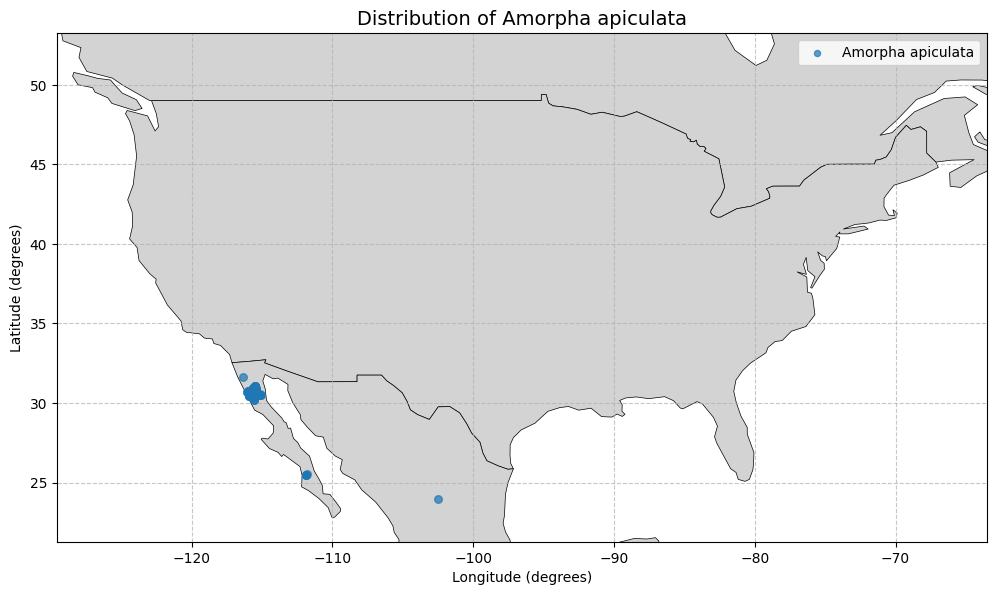

  Plotting map for: Amorpha californica


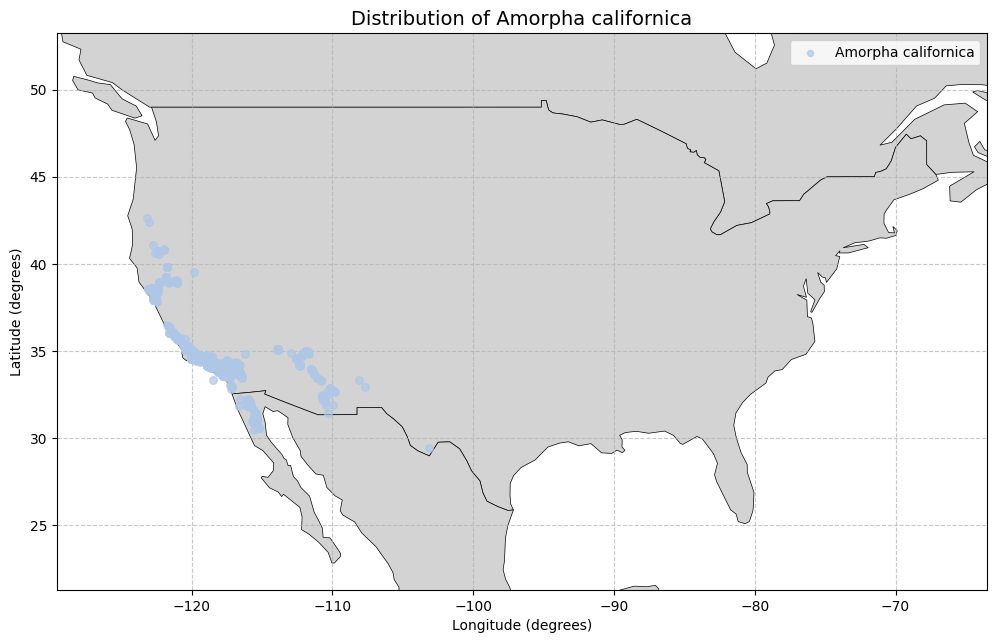

  Plotting map for: Amorpha canescens


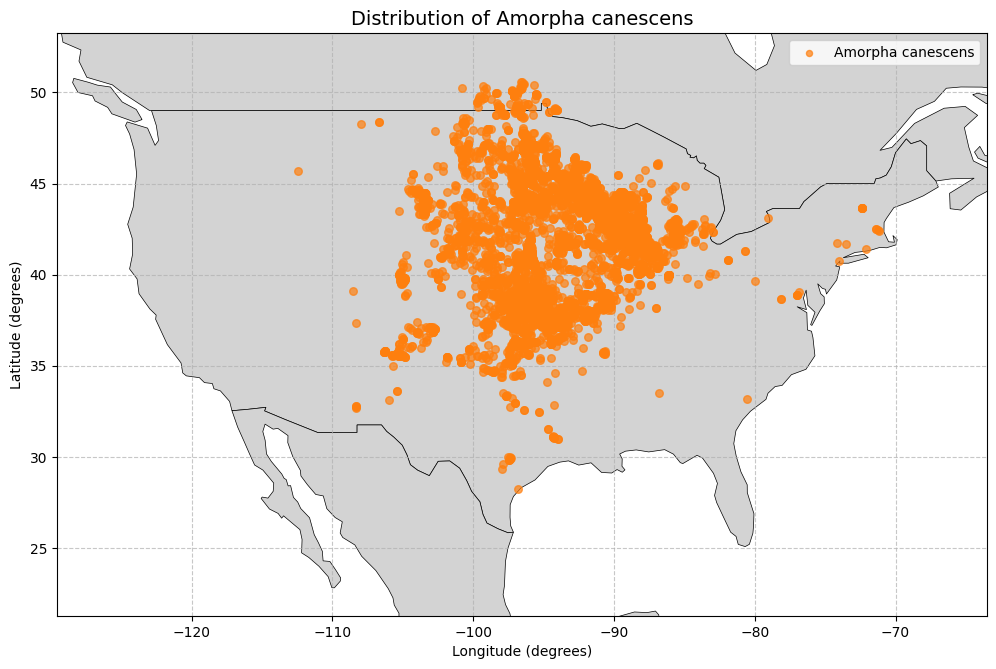

  Plotting map for: Amorpha confusa


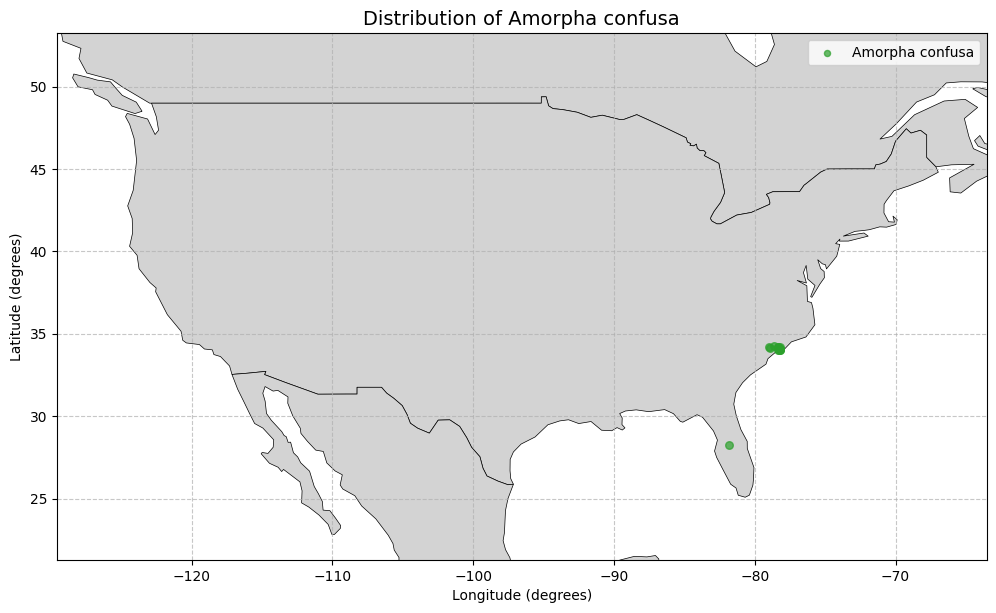

  Plotting map for: Amorpha crenulata


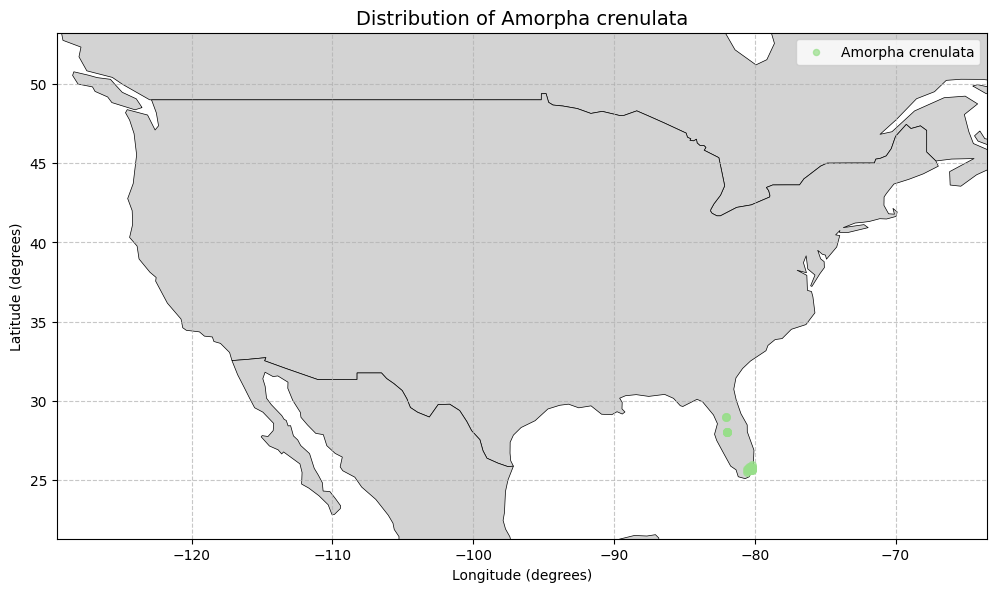

  Plotting map for: Amorpha fruticosa


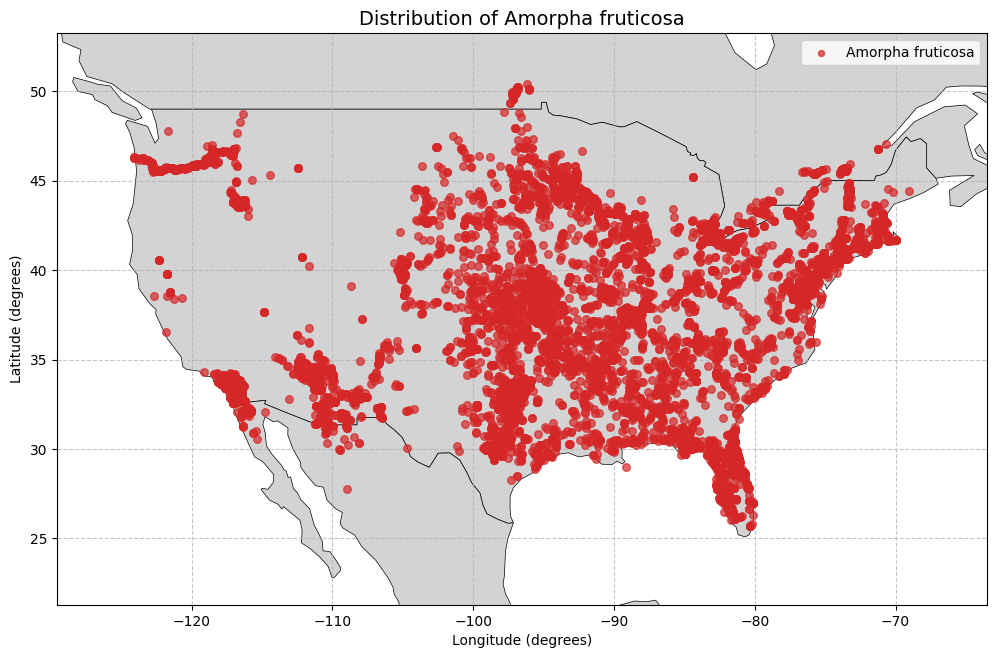

  Plotting map for: Amorpha georgiana


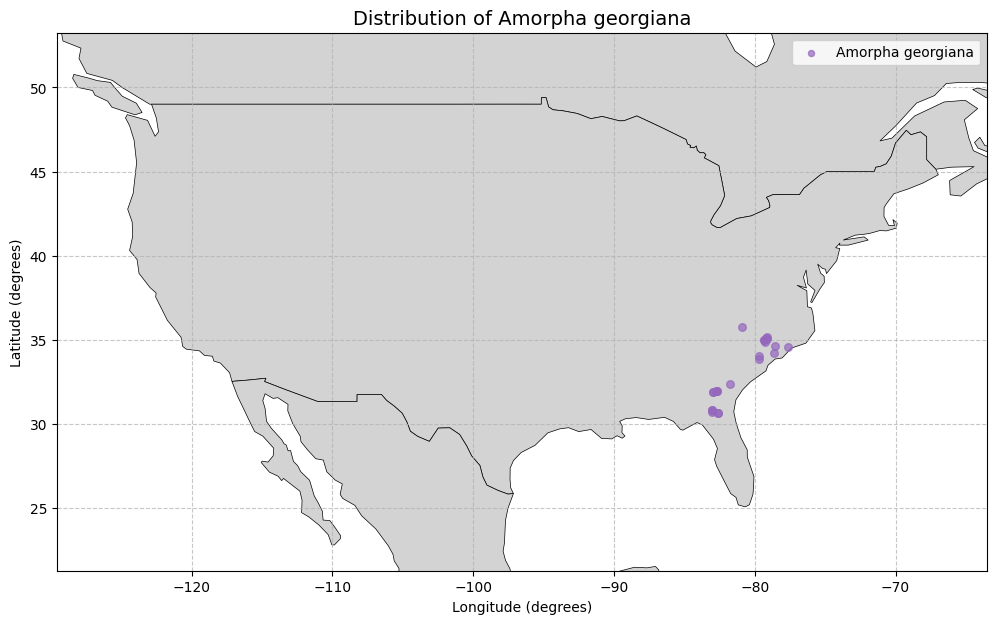

  Plotting map for: Amorpha glabra


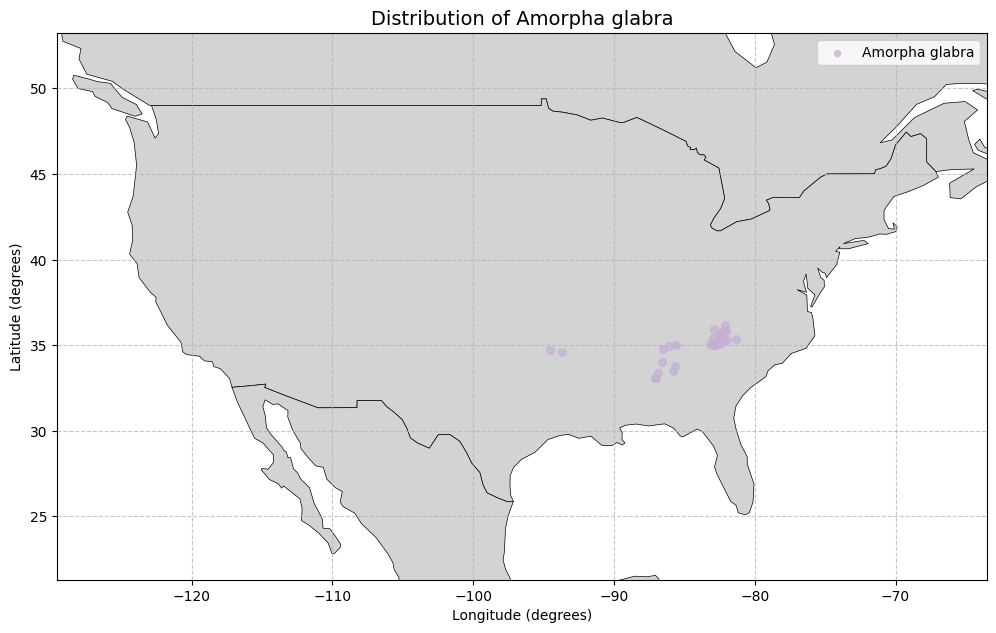

  Plotting map for: Amorpha herbacea


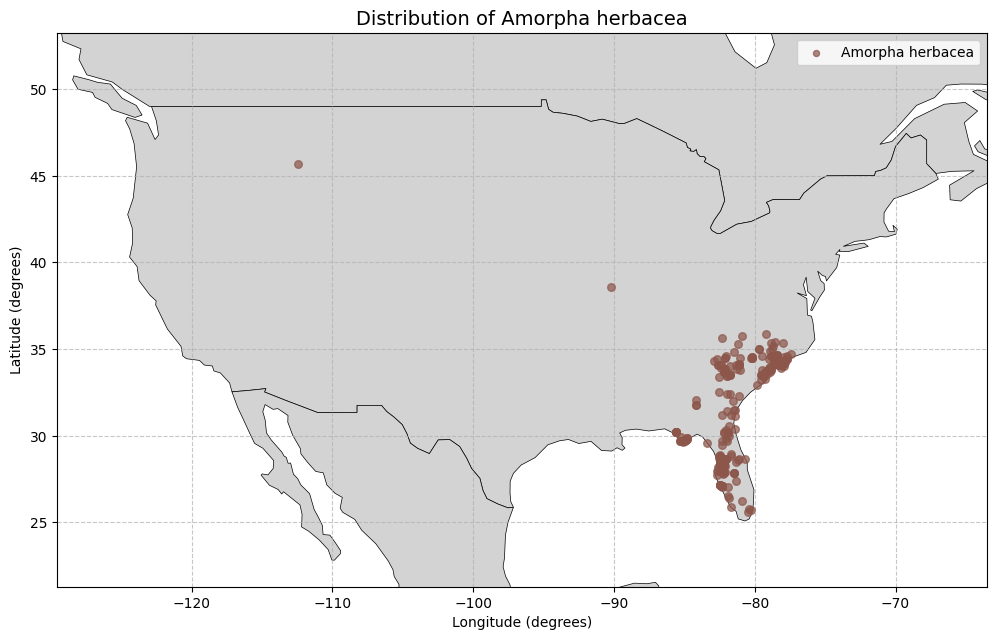

  Plotting map for: Amorpha herbacea var. floridana


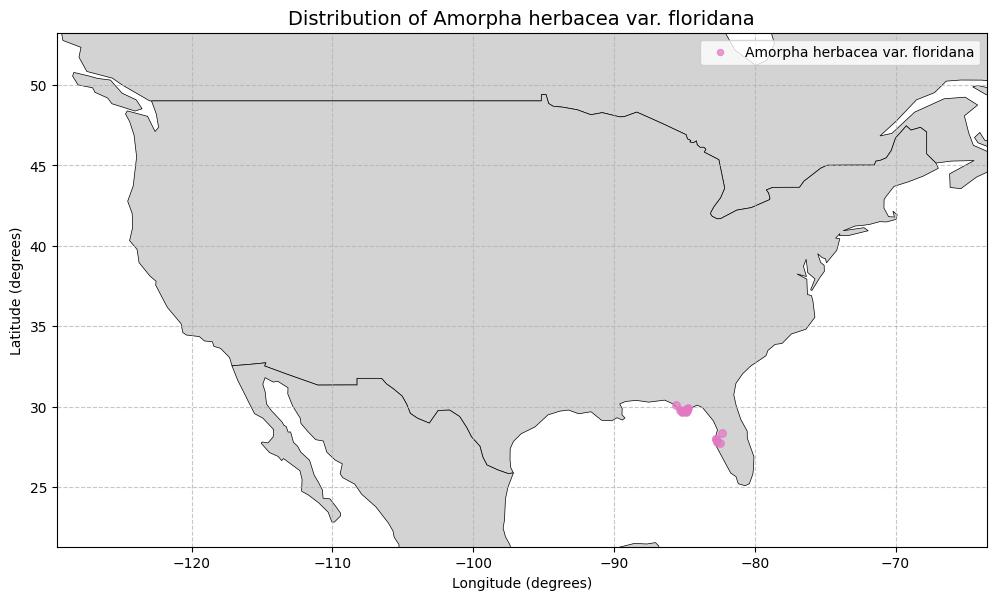

  Plotting map for: Amorpha nana


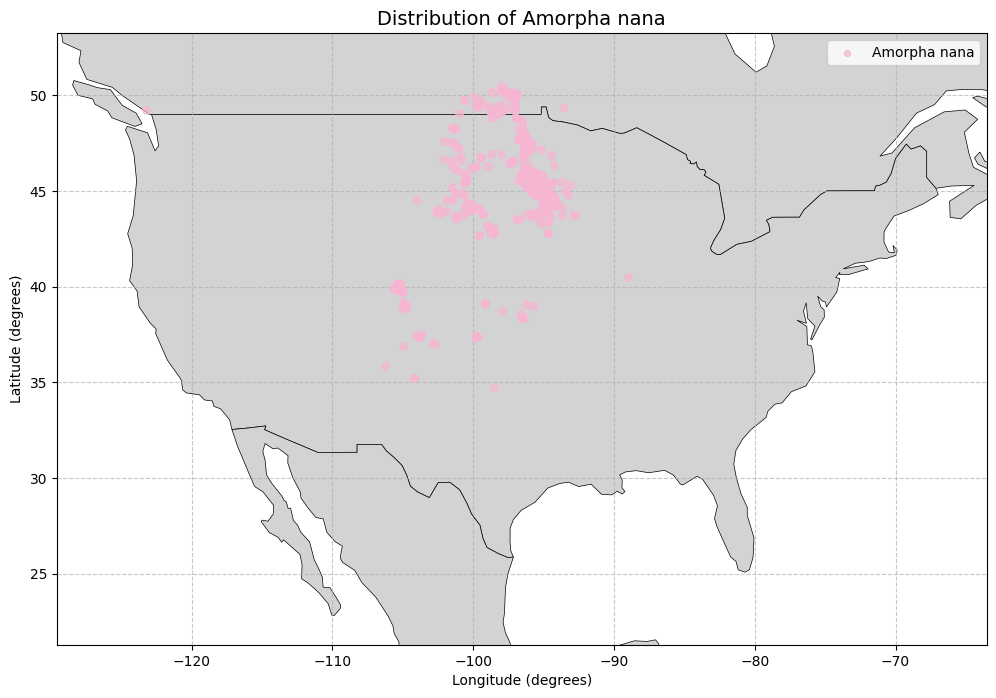

  Plotting map for: Amorpha nitens


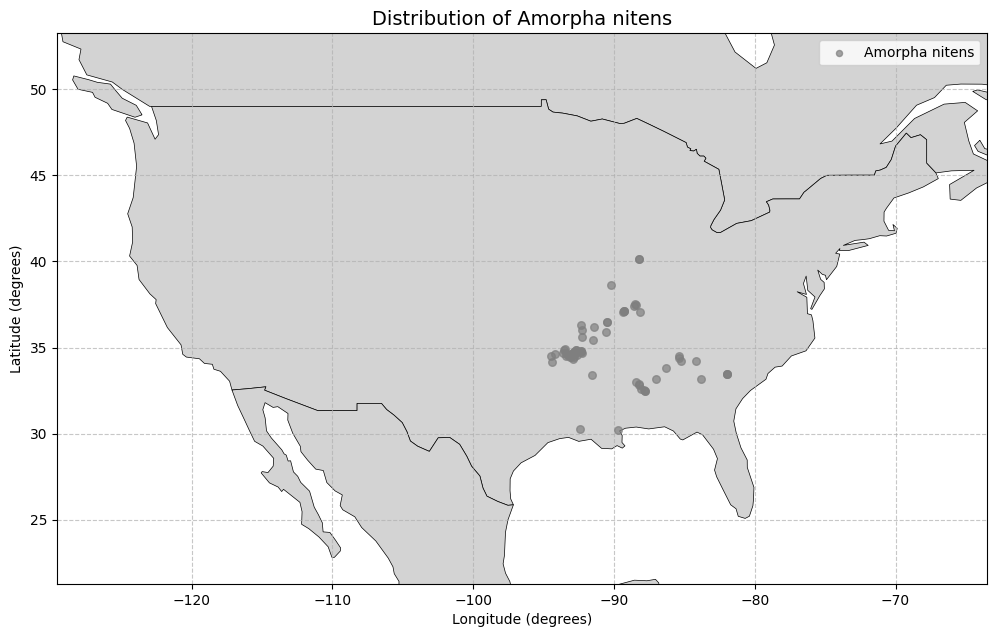

  Plotting map for: Amorpha ouachitensis


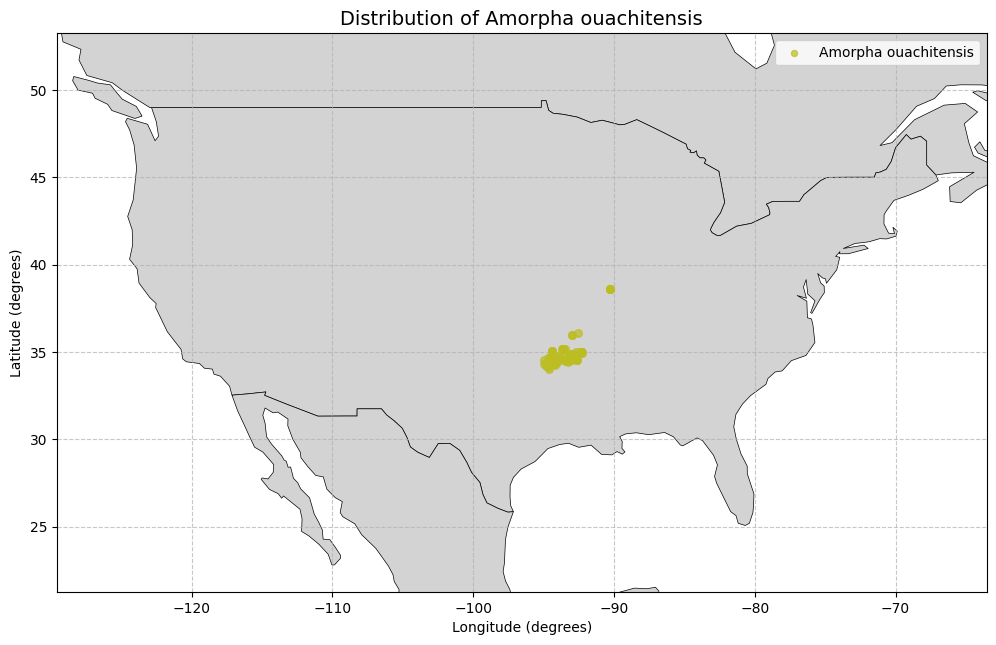

  Plotting map for: Amorpha paniculata


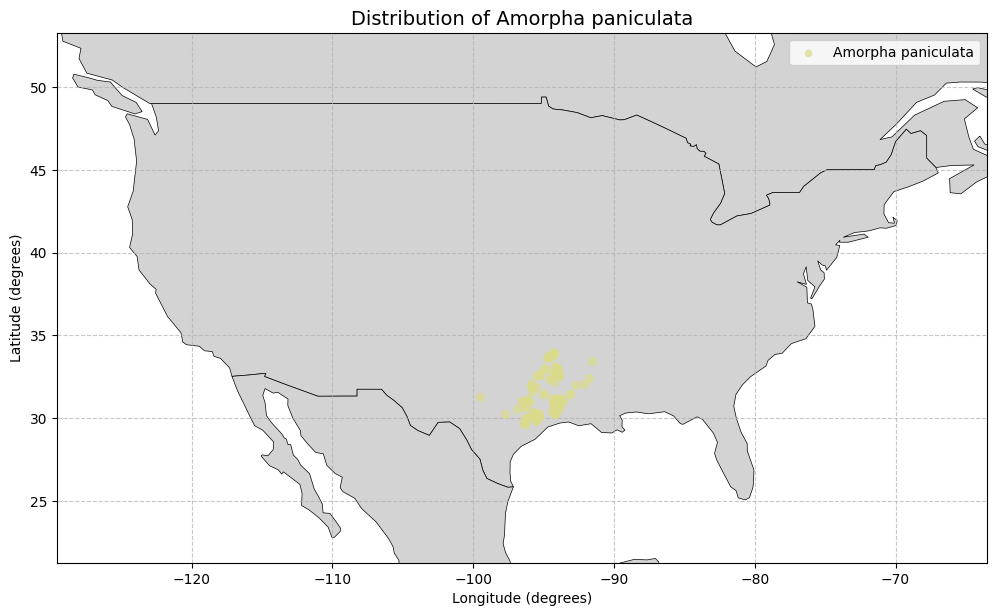

  Plotting map for: Amorpha roemeriana


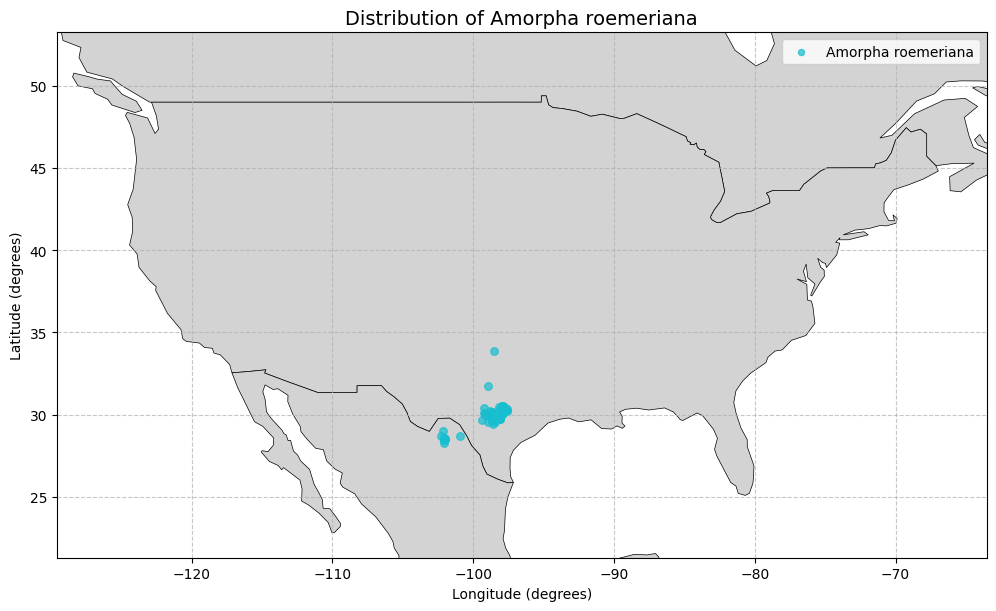

  Plotting map for: Amorpha schwerinii


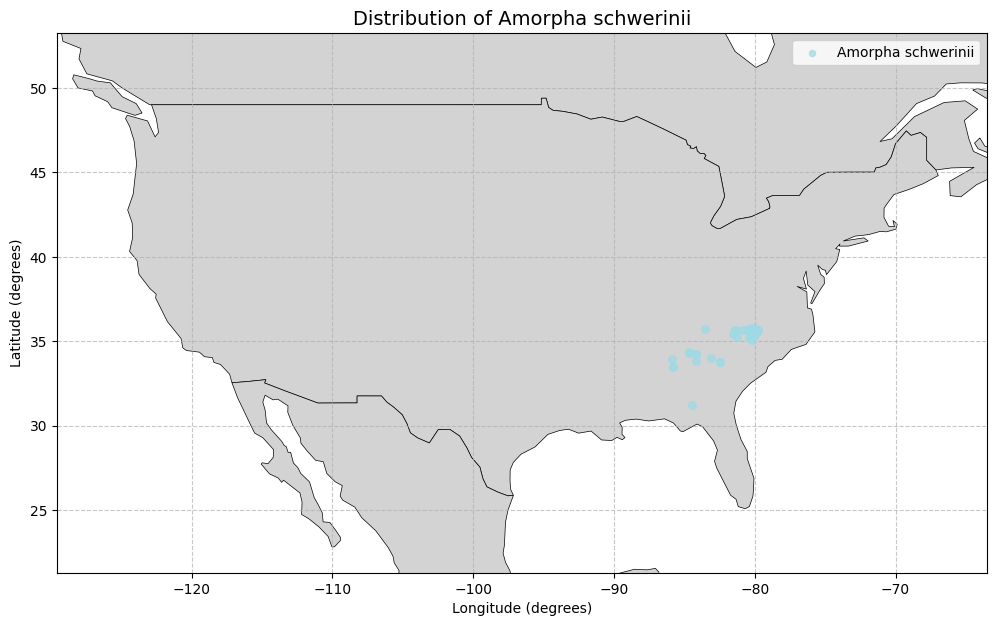


Individual flat species mapping process complete.


In [ ]:
# --- Setup: Load or Create Prerequisite Data ---
# (Ensuring gdf_all_occurrences_unprojected, north_america_map_unprojected,
#  unique_species_in_data, and species_colors are available in EPSG:4326)

# 1. Occurrence Data (gdf_all_occurrences_unprojected in EPSG:4326)
if 'gdf_all_occurrences_unprojected' not in globals() or \
   ('empty' in dir(gdf_all_occurrences_unprojected) and gdf_all_occurrences_unprojected.empty):
    print("Setup: 'gdf_all_occurrences_unprojected' not found/empty. Creating placeholder.")
    placeholder_occurrence_data = pd.DataFrame({
        'decimalLatitude': [34.0, 36.5, 38.0, 33.5, 40.0, 42.5, 28.0, 30.0, 35.0], 
        'decimalLongitude': [-118.2, -120.0, -119.5, -117.0, -75.0, -73.0, -82.0, -81.0, -95.0],
        'simpSciName': ['Amorpha californica', 'Amorpha californica', 'Amorpha californica', 'Amorpha californica', 
                        'Species B (East)', 'Species B (East)', 'Species C (South)', 'Species C (South)', 'Species D (Central)'],
        'key': range(9)
    })
    gdf_all_occurrences_unprojected = gpd.GeoDataFrame(
        placeholder_occurrence_data,
        geometry=gpd.points_from_xy(placeholder_occurrence_data.decimalLongitude, 
                                     placeholder_occurrence_data.decimalLatitude),
        crs="EPSG:4326"
    )
else:
    print("Setup: Using existing 'gdf_all_occurrences_unprojected'.")
    if not isinstance(gdf_all_occurrences_unprojected, gpd.GeoDataFrame):
        try:
            gdf_all_occurrences_unprojected = gpd.GeoDataFrame(
                gdf_all_occurrences_unprojected,
                geometry=gpd.points_from_xy(gdf_all_occurrences_unprojected.decimalLongitude, gdf_all_occurrences_unprojected.decimalLatitude),
                crs="EPSG:4326")
        except Exception as e: print(f"Error converting to GDF: {e}")
    elif gdf_all_occurrences_unprojected.crs is None or gdf_all_occurrences_unprojected.crs.to_string() != "EPSG:4326":
        gdf_all_occurrences_unprojected = gdf_all_occurrences_unprojected.to_crs("EPSG:4326")

# 2. North America Basemap (north_america_map_unprojected in EPSG:4326)
if 'north_america_map_unprojected' not in globals() or \
   north_america_map_unprojected is None or \
   ('empty' in dir(north_america_map_unprojected) and north_america_map_unprojected.empty):
    print("Setup: 'north_america_map_unprojected' not found/empty.")
    shapefile_path_actual = 'data/AOI/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp' 
    try:
        if os.path.exists(shapefile_path_actual):
            world_temp = gpd.read_file(shapefile_path_actual)
            if world_temp.crs is None: world_temp = world_temp.set_crs("EPSG:4326", allow_override=True)
            north_america_map_unprojected = world_temp[world_temp['ADMIN'].isin(['United States of America', 'Canada', 'Mexico'])]
            if north_america_map_unprojected.empty: 
                 north_america_map_unprojected = world_temp[world_temp['ADMIN'].isin(['United States', 'Canada', 'Mexico'])] # Try alternate name
            if north_america_map_unprojected.empty: 
                north_america_map_unprojected = gpd.GeoDataFrame({'name': ['Placeholder NA Base Map']}, geometry=[box(-179, 10, -50, 85)], crs="EPSG:4326")
            else: north_america_map_unprojected = north_america_map_unprojected.to_crs("EPSG:4326")
        else: raise FileNotFoundError 
    except Exception as e:
        print(f"Setup Error for basemap: {e}. Using placeholder.")
        north_america_map_unprojected = gpd.GeoDataFrame({'name': ['Placeholder NA Base Map']}, geometry=[box(-179, 10, -50, 85)], crs="EPSG:4326")
else:
    print("Setup: Using existing 'north_america_map_unprojected'.")
    if north_america_map_unprojected.crs is None or north_america_map_unprojected.crs.to_string() != "EPSG:4326":
        north_america_map_unprojected = north_america_map_unprojected.to_crs("EPSG:4326")

# 3. Unique Species List & 4. Colors
if 'unique_species_in_data' not in globals() or not unique_species_in_data:
    if not gdf_all_occurrences_unprojected.empty and 'simpSciName' in gdf_all_occurrences_unprojected.columns:
        unique_species_in_data = sorted(list(gdf_all_occurrences_unprojected['simpSciName'].dropna().unique()))
    else: unique_species_in_data = ['Amorpha californica', 'Species B (East)', 'Species C (South)', 'Species D (Central)'] 
if 'species_colors' not in globals() or not species_colors or not all(s in species_colors for s in unique_species_in_data):
    try: # Use seaborn for nicer palettes if available
        import seaborn as sns; palette_gen = sns.color_palette("husl", len(unique_species_in_data) if unique_species_in_data else 1)
    except ImportError: cmap_gen = plt.cm.get_cmap('tab10', len(unique_species_in_data) if unique_species_in_data else 1); palette_gen = [cmap_gen(i) for i in range(len(unique_species_in_data) if unique_species_in_data else 1)]
    species_colors = {name: palette_gen[i] for i, name in enumerate(unique_species_in_data)}
# --- End of Setup ---


# --- Determine Overall Map Extent for "Flat" Maps (EPSG:4326 degrees) ---
overall_map_lim_min_lon = -125.0 
overall_map_lim_max_lon = -65.0
overall_map_lim_min_lat = 20.0
overall_map_lim_max_lat = 55.0 # Default values

if not gdf_all_occurrences_unprojected.empty:
    # Get bounds from the geometry column of the GeoDataFrame
    min_lon_all_data, min_lat_all_data, max_lon_all_data, max_lat_all_data = gdf_all_occurrences_unprojected.total_bounds
    
    lon_span = max_lon_all_data - min_lon_all_data
    lat_span = max_lat_all_data - min_lat_all_data

    # Add a 10% buffer, with a minimum of 1 degree
    lon_buffer_overall = max(lon_span * 0.10, 1.0) 
    lat_buffer_overall = max(lat_span * 0.10, 1.0) 
    
    overall_map_lim_min_lon = min_lon_all_data - lon_buffer_overall
    overall_map_lim_max_lon = max_lon_all_data + lon_buffer_overall
    overall_map_lim_min_lat = min_lat_all_data - lat_buffer_overall
    overall_map_lim_max_lat = max_lat_all_data + lat_buffer_overall
    print(f"Calculated Overall Map Extent (EPSG:4326): Lon [{overall_map_lim_min_lon:.2f}, {overall_map_lim_max_lon:.2f}], Lat [{overall_map_lim_min_lat:.2f}, {overall_map_lim_max_lat:.2f}]")
else:
    print(f"Warning: Occurrence data is empty. Using default map extent: Lon [{overall_map_lim_min_lon:.2f}, {overall_map_lim_max_lon:.2f}], Lat [{overall_map_lim_min_lat:.2f}, {overall_map_lim_max_lat:.2f}]")

# Define Ticks based on the new overall extent (optional, but good for consistency)
lon_tick_step = 10.0 # Adjust step as needed
min_lon_tick = np.ceil(overall_map_lim_min_lon / lon_tick_step) * lon_tick_step
max_lon_tick = np.floor(overall_map_lim_max_lon / lon_tick_step) * lon_tick_step
lon_ticks = np.arange(min_lon_tick, max_lon_tick + lon_tick_step * 0.1, lon_tick_step)

lat_tick_step = 5.0 # Adjust step as needed
min_lat_tick = np.ceil(overall_map_lim_min_lat / lat_tick_step) * lat_tick_step
max_lat_tick = np.floor(overall_map_lim_max_lat / lat_tick_step) * lat_tick_step
lat_ticks = np.arange(min_lat_tick, max_lat_tick + lat_tick_step * 0.1, lat_tick_step)
# --- End of Extent and Tick Calculation ---


# --- Plotting Individual "Flat" Maps with Common Extent ---
if gdf_all_occurrences_unprojected.empty or north_america_map_unprojected.empty or not species_colors or not unique_species_in_data:
    print("Skipping flat maps due to missing data, basemap, colors, or species list after setup.")
else:
    print("\nGenerating individual 'flat' maps with common extent for each species...")
    new_marker_size = 30

    for species_name_to_plot in unique_species_in_data:
        print(f"  Plotting map for: {species_name_to_plot}")
        
        gdf_species_subset = gdf_all_occurrences_unprojected[
            gdf_all_occurrences_unprojected['simpSciName'] == species_name_to_plot
        ].copy() # Use .copy()

        # No need to reproject species_subset as it's already in EPSG:4326
        # No need to reproject basemap as it's also in EPSG:4326

        fig, ax = plt.subplots(1, 1, figsize=(12, 9)) # Adjust figsize as needed for flat maps
        
        # Plot the unprojected basemap
        north_america_map_unprojected.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, zorder=1)
        
        if not gdf_species_subset.empty:
            gdf_species_subset.plot(
                ax=ax, marker='o', 
                color=species_colors.get(species_name_to_plot, 'purple'), 
                markersize=new_marker_size, # Use new marker size
                alpha=0.7, 
                label=species_name_to_plot,
                zorder=2
            )
        
        ax.set_title(f'Distribution of {species_name_to_plot}', fontsize=14)
        ax.set_xlabel("Longitude (degrees)", fontsize=10)
        ax.set_ylabel("Latitude (degrees)", fontsize=10)
        
        # Apply the common overall map extent and ticks
        ax.set_xlim(overall_map_lim_min_lon, overall_map_lim_max_lon)
        ax.set_ylim(overall_map_lim_min_lat, overall_map_lim_max_lat)
        ax.set_xticks(lon_ticks)
        ax.set_yticks(lat_ticks)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        if not gdf_species_subset.empty : # Only show legend if there are points
            ax.legend(loc='best', markerscale=0.8)

        # Optional: Force aspect ratio if desired for the flat map, e.g., make degrees look somewhat square
        # ax.set_aspect('equal', adjustable='box') # This will make lat/lon degrees visually equal
                                                 # May result in a map that doesn't fill the figsize well.
                                                 # Comment out if you prefer the map to fill the figure.

        plt.show()
print("\nIndividual flat species mapping process complete.")



Generating final 'flat' map with all species and a color key...


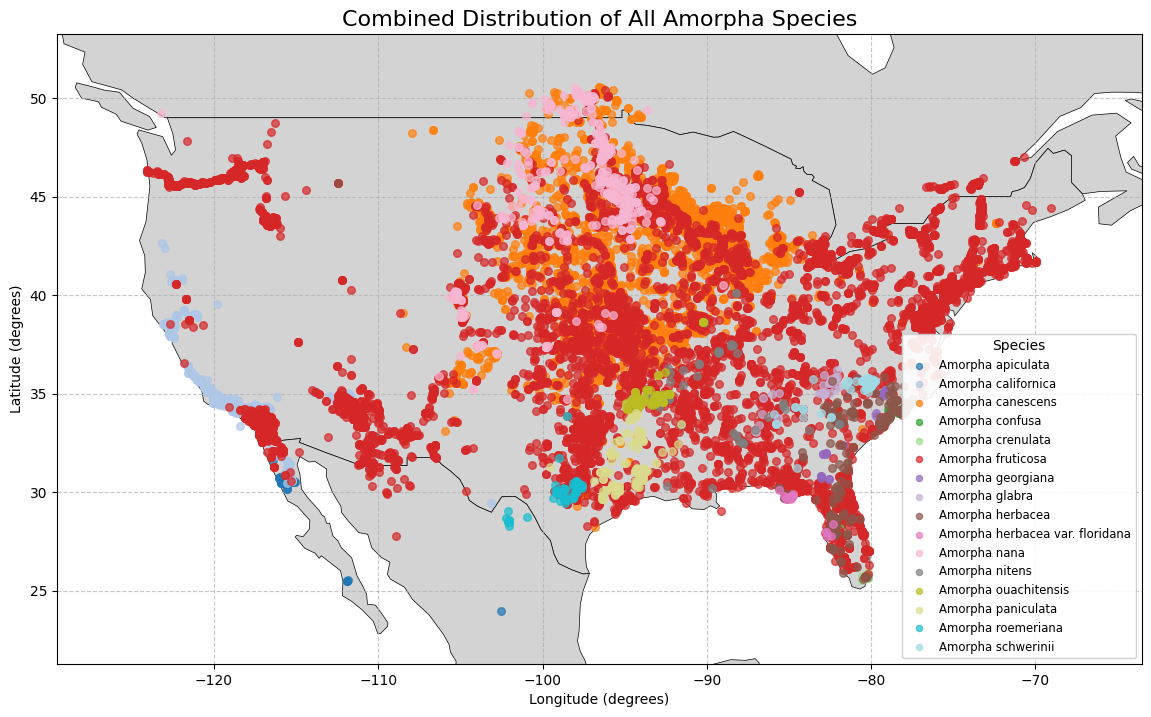


Final combined species map generation complete.


In [79]:
# Check if essential variables are present
missing_vars_final_map = []
if 'gdf_all_occurrences_unprojected' not in globals() or gdf_all_occurrences_unprojected.empty:
    missing_vars_final_map.append('gdf_all_occurrences_unprojected')
if 'north_america_map_unprojected' not in globals() or north_america_map_unprojected.empty:
    missing_vars_final_map.append('north_america_map_unprojected')
if 'unique_species_in_data' not in globals() or not unique_species_in_data:
    missing_vars_final_map.append('unique_species_in_data')
if 'species_colors' not in globals() or not species_colors:
    missing_vars_final_map.append('species_colors')
if 'overall_map_lim_min_lon' not in globals(): # Check one of the extent vars
    missing_vars_final_map.append('overall map limit variables (e.g., overall_map_lim_min_lon)')
if 'new_marker_size' not in globals():
    print("Warning: 'new_marker_size' not defined, defaulting to 48 for the final map.")
    new_marker_size = 48


if missing_vars_final_map:
    print(f"Skipping final combined map due to missing prerequisite variables: {', '.join(missing_vars_final_map)}")
else:
    print("\nGenerating final 'flat' map with all species and a color key...")

    fig, ax = plt.subplots(1, 1, figsize=(14, 10)) # Adjusted figsize for map with legend

    # 1. Plot the unprojected basemap
    north_america_map_unprojected.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, zorder=1)

    # 2. Plot each species
    for species_name_to_plot in unique_species_in_data:
        gdf_species_subset = gdf_all_occurrences_unprojected[
            gdf_all_occurrences_unprojected['simpSciName'] == species_name_to_plot
        ]
        
        if not gdf_species_subset.empty:
            gdf_species_subset.plot(
                ax=ax, 
                marker='o', 
                color=species_colors.get(species_name_to_plot, 'grey'), # Use grey as fallback
                markersize=new_marker_size, 
                alpha=0.7, 
                label=species_name_to_plot, # This label is used by ax.legend()
                zorder=2
            )

    # 3. Set map title, labels, extent, and ticks
    ax.set_title('Combined Distribution of All Amorpha Species', fontsize=16)
    ax.set_xlabel("Longitude (degrees)", fontsize=10)
    ax.set_ylabel("Latitude (degrees)", fontsize=10)
    
    ax.set_xlim(overall_map_lim_min_lon, overall_map_lim_max_lon)
    ax.set_ylim(overall_map_lim_min_lat, overall_map_lim_max_lat)
    
    # Ensure lon_ticks and lat_ticks are defined from the previous step's extent calculation
    if 'lon_ticks' in globals() and 'lat_ticks' in globals():
        ax.set_xticks(lon_ticks)
        ax.set_yticks(lat_ticks)
    else:
        print("Warning: lon_ticks or lat_ticks not defined. Using default ticks for the final map.")
        
    ax.grid(True, linestyle='--', alpha=0.7)

    # 4. Add Legend (Color Key)
    # Adjust legend properties for better placement and appearance
    legend = ax.legend(
        title="Species",
        loc='best', # 'best' tries to find a good spot, or specify e.g. 'upper right'
        markerscale=0.8, 
        fontsize='small',
        title_fontsize='medium',
        ncol=1 # Adjust number of columns if many species
    )
    if legend: # Ensure legend was created
        legend.get_frame().set_alpha(0.9) # Make legend background slightly transparent

    # Optional: Set aspect ratio for the flat map
    # ax.set_aspect('equal', adjustable='box') # Uncomment if you want degrees to be visually ~square

    plt.show()
    print("\nFinal combined species map generation complete.")
